Programming assignment 5: spotting cars using convolutional neural networks

In [1]:
# import needed libraries for all the sections
import pandas as pd 
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

Let's read the images in the training set.

Found 1600 images belonging to 2 classes.
The form of the images in the batch are as: (32, 64, 64, 3)
Corresponding lable is:  1.0


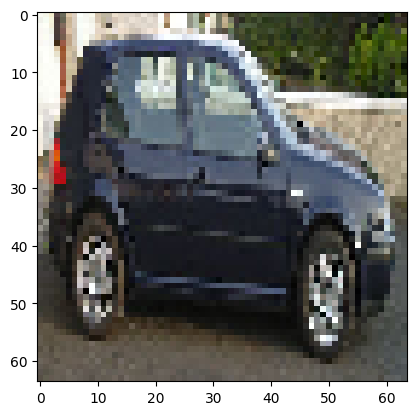

In [2]:

# set directory for the training images, image size, and batch size
imgdir = './a5_images' 
img_size = 64
batch_size = 32

# create an instance of the ImageDataGenerator class with rescaling
data_gen = ImageDataGenerator(rescale=1.0/255)

# generate batches of image data from the train directory
train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

# extract batch of image and label data
Xbatch, Ybatch = train_generator.next()

# print the shape of the image batch
print("The form of the images in the batch are as:",Xbatch.shape)

# display an image in the batch and its corresponding label
plt.imshow(Xbatch[4]);
print("Corresponding lable is: " ,Ybatch[4])

Here we use the ImageDataGenerator class and create a generator for image data with a rescale factor of 1/255. We then use the flow_from_directory method to create a generator for the training data with 1600 images belonging to 2 classes i.e., "other" and "car"). The generator is set to shuffle the data and using a seed of 12345.
The shape of the images in the batch is observed to be (32, 64, 64, 3), and the label of the 5th image in the batch is 1.0, implying it belongs to the "car" class. That is visualized using plt.imshow as well.

Transform the validation images

In [3]:
# generate batches of image data from the validation directory
validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

# extract batch of image and label data
Xvalidate, Yvalidate = validation_generator.next()

Found 576 images belonging to 2 classes.


Part 1: Training a convolutional neural network

In [4]:
# define a function to create the CNN model
def make_convnet(img_size_width, img_size_height):
    
    model = keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(5,5), strides=(1,1),
                            activation = 'relu', 
                            input_shape = (img_size_width, img_size_height, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides =(2,2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
  	
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    model.summary()

    return model

# create the model with image size of 64x64
model_1 = make_convnet(64 , 64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 1000)              1

Here, we define a CNN using Keras. The model architecture consists of two Convolutional layers with 32 and 64 filters, respectively. Then the mo  
Each convolutional layer is followed by a MaxPooling layer to reduce the spatial dimensions of the output feature maps. The model then flattens the output and passes it through a fully connected dense layer with 1000 neurons and ReLU activation. Finally, there is an output layer with a single neuron and a sigmoid activation function to produce a binary output.

The model is compiled using the binary cross-entropy loss function, Adam optimizer, and accuracy metric. The model.summary() method is called to print the summary of the model depicting the layer types, and number of trainable parameters, etc.

In [5]:

# train the model using fit method on train_generator with 15 epochs
fit_model = model_1.fit(train_generator,
                     epochs = 15,
                     verbose = 1,
                     validation_data = validation_generator)

# evaluate the model on training data
score = model_1.evaluate(Xbatch, Ybatch, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# evaluate the model on validation data
score = model_1.evaluate(Xvalidate, Yvalidate, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/15
50/50 [==============================] - 31s 586ms/step - loss: 0.7161 - accuracy: 0.6237 - val_loss: 0.5802 - val_accuracy: 0.7066
Epoch 2/15
50/50 [==============================] - 27s 537ms/step - loss: 0.5009 - accuracy: 0.7688 - val_loss: 0.5154 - val_accuracy: 0.7552
Epoch 3/15
50/50 [==============================] - 27s 539ms/step - loss: 0.4181 - accuracy: 0.8094 - val_loss: 0.4888 - val_accuracy: 0.7656
Epoch 4/15
50/50 [==============================] - 27s 545ms/step - loss: 0.3548 - accuracy: 0.8462 - val_loss: 0.5726 - val_accuracy: 0.7135
Epoch 5/15
50/50 [==============================] - 27s 549ms/step - loss: 0.3086 - accuracy: 0.8675 - val_loss: 0.5184 - val_accuracy: 0.7847
Epoch 6/15
50/50 [==============================] - 27s 542ms/step - loss: 0.2518 - accuracy: 0.8931 - val_loss: 0.5447 - val_accuracy: 0.7951
Epoch 7/15
50/50 [==============================] - 27s 541ms/step - loss: 0.1729 - accuracy: 0.9275 - val_loss: 0.6179 - val_accuracy: 0.7882

We trained the model for 15 epochs, and during each epoch, it processed 50 batches of data (each batch containing a number of images and their corresponding labels). 

The final training accuracy is 99.94% and the final validation accuracy is 78.12%. It's worth noting that the training accuracy is significantly higher than the validation accuracy, which can imply that the model may be overfitting to the training data.

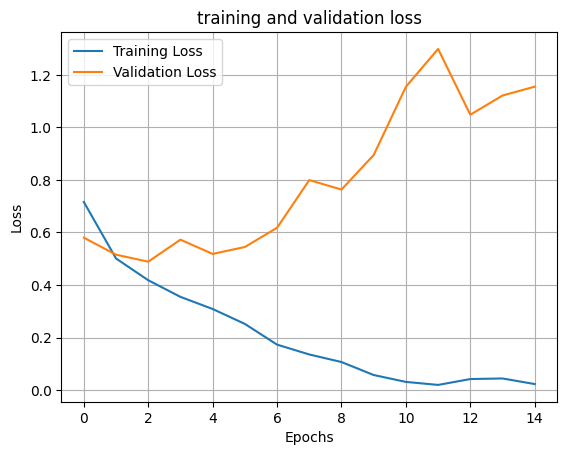

In [6]:
# plot the training and validation loss over the epochs
plt.plot(fit_model.history['loss'], label='Training Loss')
plt.plot(fit_model.history['val_loss'], label='Validation Loss')
plt.grid('both')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

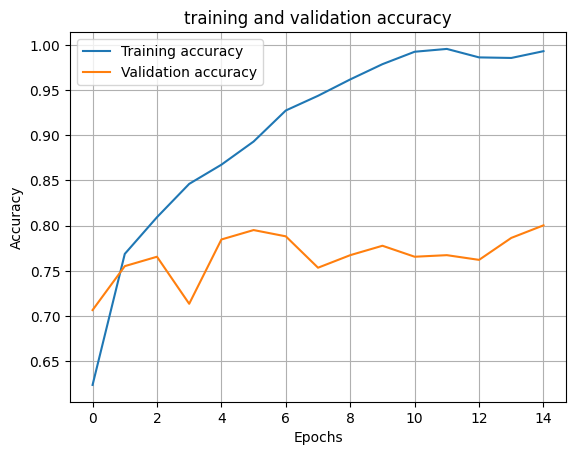

In [7]:
# plot the training and validation accuracy over the epochs
plt.plot(fit_model.history['accuracy'], label='Training accuracy')
plt.plot(fit_model.history['val_accuracy'], label='Validation accuracy')
plt.grid('both')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

The first plot shows that the training loss decreases over time as the model learns to make better predictions on the training data, but the validation loss eventually starts to increase after about 7 epochs, indicating that the model is starting to overfit to the training data.

The second plot shows that the training accuracy increases as the model learns to make better predictions on the training data, but the validation accuracy eventually starts to plateau and then decrease after about 7 epochs, again indicating that the model is starting to overfit to the training data.

Overall, these plots suggest that model_1 is overfitting to the training data and not generalizing well to new data.

Part 2: Data augmentation

In [8]:
# create an ImageDataGenerator with augmentation options
datagen_augmented = ImageDataGenerator(rescale = 1.0 / 255,
                                       horizontal_flip = True,
                                       rotation_range = 30)

# create a new training data generator with the augmentation options
train_generator_augmented = datagen_augmented.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

# create a new model with the make_convnet function
model_2 = make_convnet(64, 64)

# fit the new model using the augmented training data
model_fit = model_2.fit(train_generator_augmented,
                     epochs = 15,
                     verbose = 1,
                     validation_data = validation_generator)

Found 1600 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 10816)             0         
                                                                 
 dense_2 (De

Here, we use a CNN with two convolutional layers followed by two fully connected layers. The first convolutional layer has 32 filters and a kernel size of 3x3, and the second convolutional layer has 64 filters and a kernel size of 5x5. 

This model is then trained on augmented data generated by the ImageDataGenerator class from Keras. The data is rescaled to have pixel values between 0 and 1, and horizontal flips and random rotations up to 30 degrees are applied to the images during training.  we train it for 15 epochs with a batch size of 32, using the training data generator as input and the validation_generator for validation.

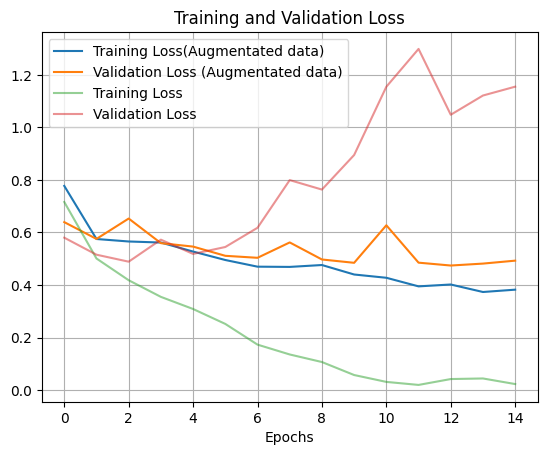

In [9]:
plt.plot(model_fit.history['loss'], '-', label='Training Loss(Augmentated data)')
plt.plot(model_fit.history['val_loss'], '-', label='Validation Loss (Augmentated data)')
plt.plot(fit_model.history['loss'], label='Training Loss', alpha=0.5)
plt.plot(fit_model.history['val_loss'], label='Validation Loss', alpha=0.5)
plt.grid('both')
plt.xlabel('Epochs')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

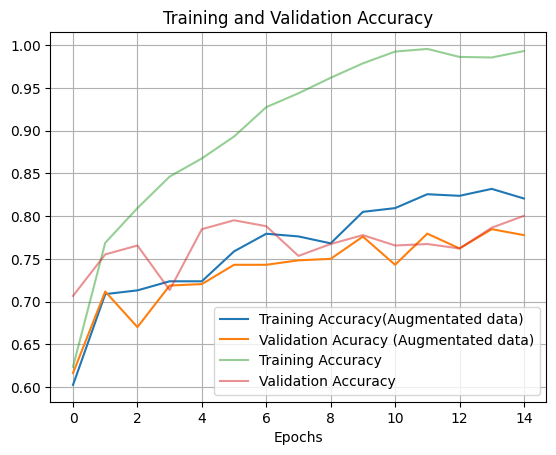

In [10]:
plt.plot(model_fit.history['accuracy'], '-', label='Training Accuracy(Augmentated data)')
plt.plot(model_fit.history['val_accuracy'], '-', label='Validation Acuracy (Augmentated data)')
plt.plot(fit_model.history['accuracy'], label='Training Accuracy', alpha=0.5)
plt.plot(fit_model.history['val_accuracy'], label='Validation Accuracy', alpha=0.5)
plt.grid('both')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

We plot the training, validation loss and accuracy over 15 epochs for neural network model. We observe that the validation loss for the for augmented data is lower implying that the performs well there reducing the overfitting. However, the validation loss in increasing depicting overfit there.

1/1 [==============================] - 2s 2s/step


[[('n04037443', 'racer', 0.6763647),
  ('n04285008', 'sports_car', 0.30587143),
  ('n02974003', 'car_wheel', 0.008879181),
  ('n03895866', 'passenger_car', 0.0028113425),
  ('n03930630', 'pickup', 0.0018079418)]]

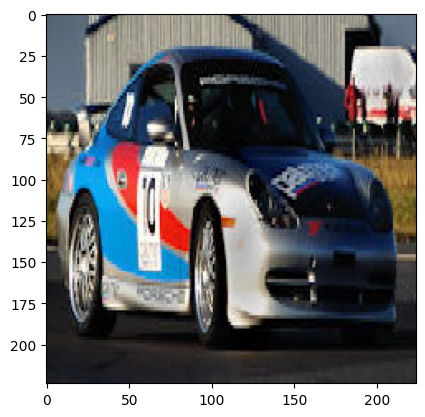

In [11]:
vggmodel = applications.VGG16(weights='imagenet', include_top=True)

image = load_img(imgdir + '/train/car/0025.jpg', target_size=(224,224))
plt.imshow(image)
image_array = img_to_array(image)
image_array = preprocess_input(image_array)
image_array = image_array.reshape(1, 224, 224, 3)

pred = vggmodel.predict(image_array)
decode_predictions(pred)

The VGG16 model correctly identified the image as a "racer" with a high confidence score of 0.676. The predictions for "sports_car" and "car_wheel" were also on top.

Part 3: Using VGG-16 as a feature extractor

In [12]:
# Load the pre-trained VGG16 model without the top layers
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))

# Define a function to generate VGG16 features
def create_vgg16_features( dir, file_name):

    vgg_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
    
    generator = vgg_data_gen.flow_from_directory(
        imgdir + dir  ,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        seed=12345,
        class_mode='binary',
        classes=['other', 'car'],
        shuffle=False )

    cnnFeatures = feature_extractor.predict(generator)

    # Save the VGG16 features
    with open(file_name, "wb") as f:
        np.save(f, cnnFeatures)

# generate and save VGG16 features for the training and validation sets
create_vgg16_features('./train', 'train_vgg16_features.npy')
create_vgg16_features( './validation','val_vgg16_features.npy')


Found 1600 images belonging to 2 classes.
50/50 [==============================] - 95s 2s/step
Found 576 images belonging to 2 classes.
18/18 [==============================] - 34s 2s/step


We define a function create_vgg16_features that generates VGG16 features for a given directory of images and saves them to a numpy file using the np.save() function. The function passes the flow of images to the feature_extractor model from the VGG16 architecture that has the top layers removed to generate the features.

Then we call the create_vgg16_features function twice in the code block to generate VGG16 features for both the training and validation data.

In [15]:
def make_model(img_size_width ,img_size_height, channel):
    
    model = keras.Sequential()
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.build((None, img_size_width, img_size_height, channel))

    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    model.summary()

    return model


In [16]:

def get_labels(n):
    return np.array([0] * (n // 2) + [1] * (n // 2))

# loading the training and valdiation data and trains the cnn classifier
def train_on_cnnfeatures():
    
    # Load the features from files
    with open('train_vgg16_features.npy', 'rb') as f:
        x_train = np.load(f)
    with open('val_vgg16_features.npy', 'rb') as f:
        x_test = np.load(f)

    # Generate the corresponding labels
    y_train = get_labels(len(x_train))
    y_test = get_labels(len(x_test))

    # build and train the model
    model_3 = make_model(x_train.shape[1], x_train.shape[2], x_train.shape[3])
    
    fit_model_3 = model_3.fit(x_train, y_train,
                     epochs = 20,
                     validation_data = (x_test, y_test))
    return fit_model_3, model_3


In [17]:

model_3, fit_model_3 = train_on_cnnfeatures()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 262,401
Trainable params: 262,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
50/50 [==============================] - 2s 16ms/step - loss: 2.1580 - accuracy: 0.8569 - val_loss: 1.1663 - val_accuracy: 0.8958
Epoch 2/20
50/50 [==============================] - 1s 10ms/step - loss: 0.2054 - accuracy: 0.9638 - val_loss: 1.0035 - val_accuracy: 0.9010
Epoch 3/20
50/50 [============

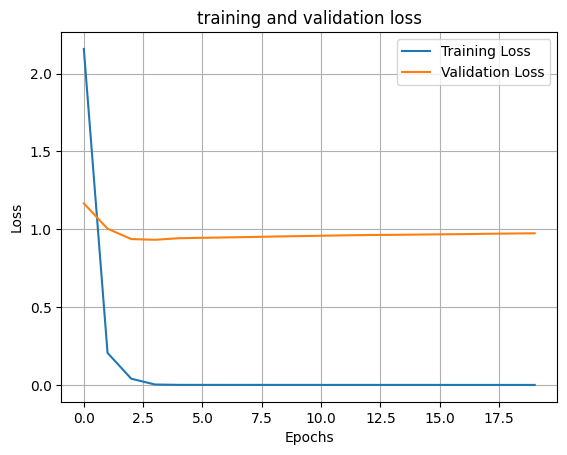

In [18]:
plt.plot(model_3.history['loss'], label='Training Loss')
plt.plot(model_3.history['val_loss'], label='Validation Loss')
plt.grid('both')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

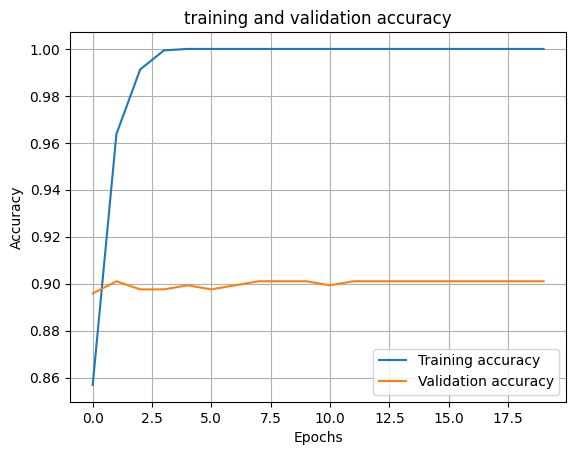

In [19]:
plt.plot(model_3.history['accuracy'], label='Training accuracy')
plt.plot(model_3.history['val_accuracy'], label='Validation accuracy')
plt.grid('both')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

In here, we create a simple binary classifier using pre-trained features extracted using VGG16. The model was trained for 20 epochs and achieves high accuracy on both the training and validation sets. We observe that the training and validation losses decreased, and the accuracy increased with each epoch. After 20 epochs, the training accuracy reached 100%, and the validation accuracy was 90.80%, implying a better fit. The model seems to be overfitting to the training data as the validation loss does not decrease as much as the training loss. Tunining the hyper-parameters may improve the performance a bit more.

Part 4

In [20]:
# Retrieve the weights of the first layer of a pre-trained VGG model
first_layer_weights = vggmodel.get_weights()[0]

first_layer_weights.shape

(3, 3, 3, 64)

As can be seen,  The shape of first_layer_weights are (3, 3, 3, 64),the first three dimensions represent the height, width, and number of input channels to the filter, and the last dimension represents the number of filters in the layer.
The output of the below function is a three-dimensional tensor of the processed kernel, which can be used to for visual representation of the convolutional kernel in the form of an image.

In [21]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k


Here  we use kernal images for visual representations of the weights learned by convolutional neural networks (CNNs) during training. The dark areas in the kernel images correspond to negative weights, while light areas correspond to positive weights. By looking at the shape of the learned weights in these plots we can get an idea of which kind of patterns the CNN was looking for in the input data. Although we used kernal images for the purpose of effective visualization, it should be noted that other factors like activation patters and layer outputs are also important when determining the CNN's behaviour

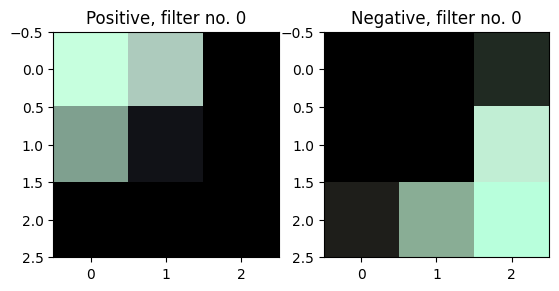

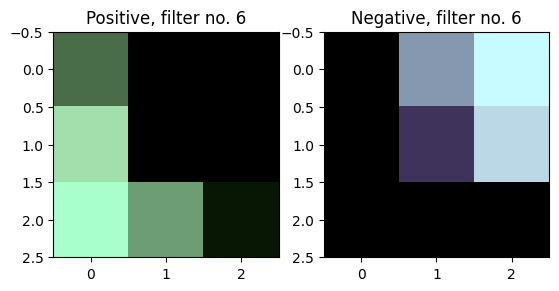

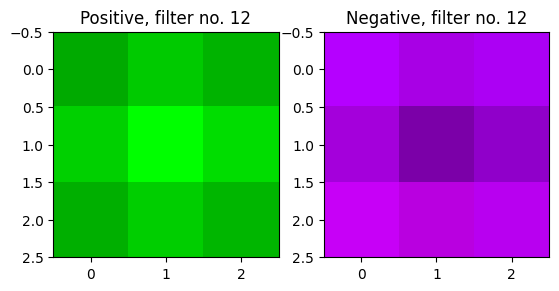

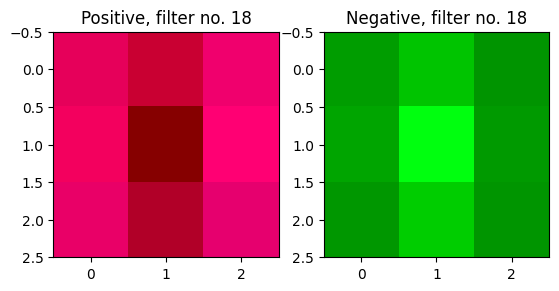

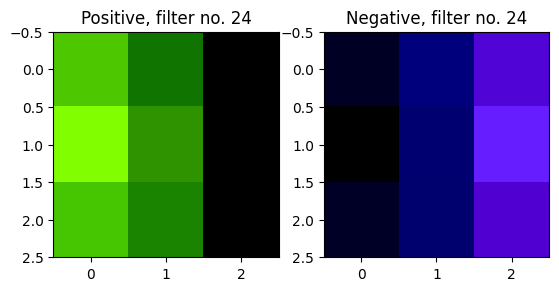

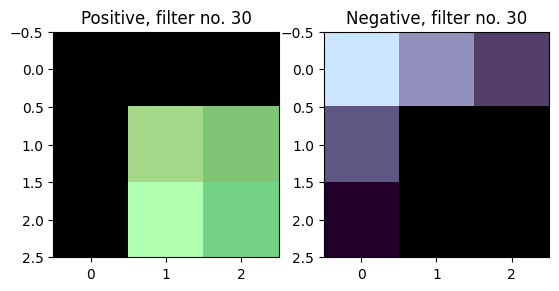

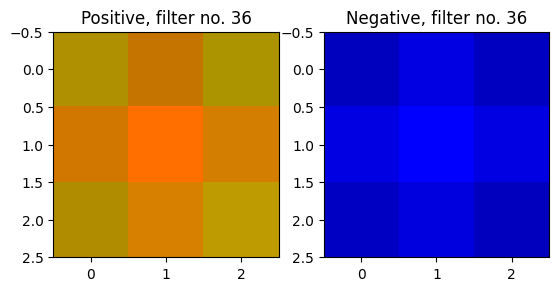

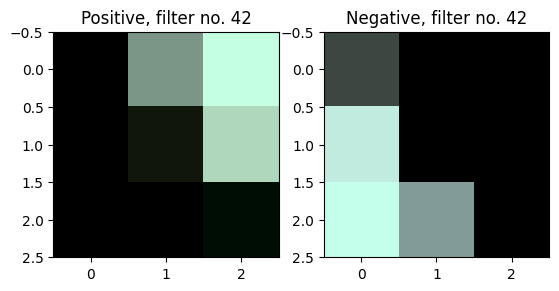

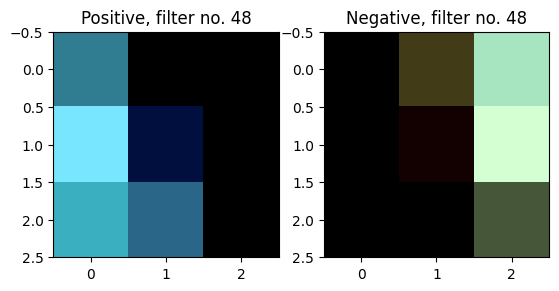

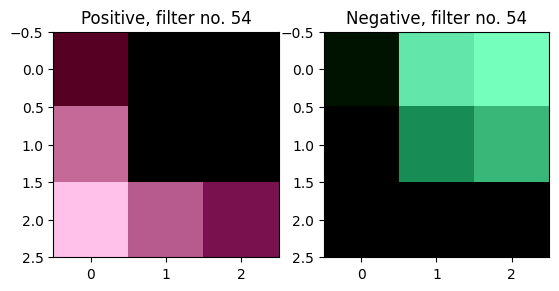

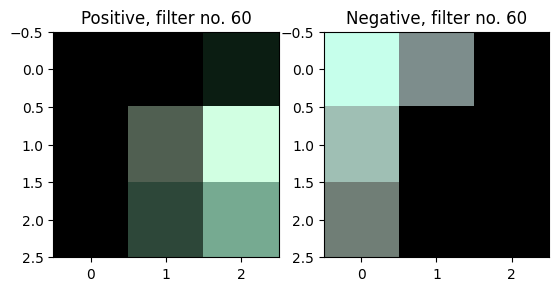

In [23]:
for i in range(0, 64, 6):


    f, axarr = plt.subplots(1, 2)

    # plot for positive kernel images
    axarr[0].imshow(kernel_image(vggmodel.get_weights()[0], i, True))
    axarr[0].set_title(f"Positive, filter no. {i}")

    # plot for negative kernel images
    axarr[1].imshow(kernel_image(vggmodel.get_weights()[0], i, False))
    axarr[1].set_title(f"Negative, filter no. {i}")

    plt.show()